# Speech Denoising Using RNN


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import GRU, Input, Flatten, Dense, Dropout, Conv2D, MaxPool2D, Dot
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import librosa
from IPython.display import Audio
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import math
from tqdm import tqdm
from itertools import combinations
from tensorflow.keras.metrics import BinaryAccuracy
import random
import pickle



## Data Prep (preprocessing)



### Data Loading

Function load_wav_files is used to load files from tr, te and v folder
Once the file is loaded, following data preprosseing activities are done


*   Converting loaded signals from Time Domain(TD) to Frequency Domain (c_FD)
*   Computing abosolute value of FD signals (FD)
*   Transposing the abosolute value matrix (FD_t)

Singals in all the stages are stored in the dict for future access for IBM mask generation, validation, and SNR calculation

In [10]:
def load_wav_files(folder_path, prefix):
    audio_dict_TD = {}
    audio_dict_FD_t = {}
    audio_dict_c_FD = {}
    audio_dict_FD = {}

    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        #return audio_dict

    files = [f for f in os.listdir(folder_path) if f.endswith('.wav') and f.startswith(prefix)]
    print('file count ', len(files))

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)

        try:
            audio_dict_TD[file_name], sr =  librosa.load(file_path, sr=None)
            s_c_FD = librosa.stft(audio_dict_TD[file_name], n_fft=1024, hop_length=512)
            audio_dict_c_FD[file_name] = s_c_FD
            s_FD = np.abs(s_c_FD)
            audio_dict_FD[file_name] = s_FD
            audio_dict_FD_t[file_name] =np.transpose(s_FD)
            print(f"file {file_name} loaded")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

    return audio_dict_TD, audio_dict_FD_t, audio_dict_FD, audio_dict_c_FD

trn_dict_TD, trn_dict_FD_t, trn_dict_FD, trn_dict_c_FD = load_wav_files('tr', 'trn')
trs_dict_TD, trs_dict_FD_t, trs_dict_FD, trs_dict_c_FD = load_wav_files('tr', 'trs')
trx_dict_TD, trx_dict_FD_t, trx_dict_FD, trx_dict_c_FD = load_wav_files('tr', 'trx')

vn_dict_TD, vn_dict_FD_t, vn_dict_FD, vn_dict_c_FD = load_wav_files('v', 'vn')
vs_dict_TD, vs_dict_FD_t, vs_dict_FD, vs_dict_c_FD = load_wav_files('v', 'vs')
vx_dict_TD, vx_dict_FD_t, vx_dict_FD, vx_dict_c_FD = load_wav_files('v', 'vx')

tex_dict_TD, tex_dict_FD_t, tex_dict_FD, tex_dict_c_FD = load_wav_files('te', 'tex')

file count  1200
file trn0000.wav loaded
file trn0001.wav loaded
file trn0002.wav loaded
file trn0003.wav loaded
file trn0004.wav loaded
file trn0005.wav loaded
file trn0006.wav loaded
file trn0007.wav loaded
file trn0008.wav loaded
file trn0009.wav loaded
file trn0010.wav loaded
file trn0011.wav loaded
file trn0012.wav loaded
file trn0013.wav loaded
file trn0014.wav loaded
file trn0015.wav loaded
file trn0016.wav loaded
file trn0017.wav loaded
file trn0018.wav loaded
file trn0019.wav loaded
file trn0020.wav loaded
file trn0021.wav loaded
file trn0022.wav loaded
file trn0023.wav loaded
file trn0024.wav loaded
file trn0025.wav loaded
file trn0026.wav loaded
file trn0027.wav loaded
file trn0028.wav loaded
file trn0029.wav loaded
file trn0030.wav loaded
file trn0031.wav loaded
file trn0032.wav loaded
file trn0033.wav loaded
file trn0034.wav loaded
file trn0035.wav loaded
file trn0036.wav loaded
file trn0037.wav loaded
file trn0038.wav loaded
file trn0039.wav loaded
file trn0040.wav loaded

### IBM Mask Generation

Function get_IBM is used to fecth a perticular signal from Dict and feed it to Fuction extract_IBM for Mask Generation

In [4]:
def extract_IBM(signal_FD, noise_FD):
    mask_t = []
    mask = []
    for i in range(len(noise_FD)):
        ibm = []
        for j in range(len(noise_FD[i])):
            if signal_FD[i][j] > noise_FD[i][j]:
                ibm.append(1)
            else:
                ibm.append(0)
        mask.append(ibm)
    mask_t = np.transpose(mask)
    return mask_t

def get_IBM(signal_dict_FD, noise_dict_FD, signal_prefix, noise_prefix, noisy_signal_prefix):
    ibm_dict_t={}

    numbers = ['0000','000','00','0']

    for i in range(1200):
        if i == 0:
            ibm_dict_t[noisy_signal_prefix+str(numbers[0])+'.wav'] = extract_IBM(signal_dict_FD[signal_prefix+str(numbers[0])+'.wav'], noise_dict_FD[noise_prefix+str(numbers[0])+'.wav'])
            print('Mask for ', noisy_signal_prefix+str(numbers[0])+'.wav', ' is inserted for signal ', signal_prefix+str(numbers[0])+'.wav', ' and noise ', noise_prefix+str(numbers[0])+'.wav' )

        if i > 0 and i < 10:
            ibm_dict_t[noisy_signal_prefix+str(numbers[1])+str(i)+'.wav'] = extract_IBM(signal_dict_FD[signal_prefix+str(numbers[1])+str(i)+'.wav'], noise_dict_FD[noise_prefix+str(numbers[1])+str(i)+'.wav'])
            print('Mask for ', noisy_signal_prefix+str(numbers[1])+str(i)+'.wav', ' is inserted for signal ', signal_prefix+str(numbers[1])+str(i)+'.wav', ' and noise ', noise_prefix+str(numbers[1])+str(i)+'.wav' )

        if i > 9 and i < 100:
            ibm_dict_t[noisy_signal_prefix+str(numbers[2])+str(i)+'.wav'] = extract_IBM(signal_dict_FD[signal_prefix+str(numbers[2])+str(i)+'.wav'], noise_dict_FD[noise_prefix+str(numbers[2])+str(i)+'.wav'])
            print('Mask for ', noisy_signal_prefix+str(numbers[2])+str(i)+'.wav', ' is inserted for signal ', signal_prefix+str(numbers[2])+str(i)+'.wav', ' and noise ', noise_prefix+str(numbers[2])+str(i)+'.wav' )

        if i > 99 and i < 1000:
            ibm_dict_t[noisy_signal_prefix+str(numbers[3])+str(i)+'.wav'] = extract_IBM(signal_dict_FD[signal_prefix+str(numbers[3])+str(i)+'.wav'], noise_dict_FD[noise_prefix+str(numbers[3])+str(i)+'.wav'])
            print('Mask for ', noisy_signal_prefix+str(numbers[3])+str(i)+'.wav', ' is inserted for signal ', signal_prefix+str(numbers[3])+str(i)+'.wav', ' and noise ', noise_prefix+str(numbers[3])+str(i)+'.wav' )

        if i > 999 and i < 1200:
            ibm_dict_t[noisy_signal_prefix+str(i)+'.wav'] = extract_IBM(signal_dict_FD[signal_prefix+str(i)+'.wav'], noise_dict_FD[noise_prefix+str(i)+'.wav'])
            print('Mask for ', noisy_signal_prefix+str(i)+'.wav', ' is inserted for signal ', signal_prefix+str(i)+'.wav', ' and noise ', noise_prefix+str(i)+'.wav' )

    return ibm_dict_t

trx_ibm_dict_t = get_IBM(trs_dict_FD, trn_dict_FD, 'trs', 'trn', 'trx')
vx_ibm_dict_t = get_IBM(vs_dict_FD, vn_dict_FD, 'vs', 'vn', 'vx')

Mask for  trx0000.wav  is inserted for signal  trs0000.wav  and noise  trn0000.wav
Mask for  trx0001.wav  is inserted for signal  trs0001.wav  and noise  trn0001.wav
Mask for  trx0002.wav  is inserted for signal  trs0002.wav  and noise  trn0002.wav
Mask for  trx0003.wav  is inserted for signal  trs0003.wav  and noise  trn0003.wav
Mask for  trx0004.wav  is inserted for signal  trs0004.wav  and noise  trn0004.wav
Mask for  trx0005.wav  is inserted for signal  trs0005.wav  and noise  trn0005.wav
Mask for  trx0006.wav  is inserted for signal  trs0006.wav  and noise  trn0006.wav
Mask for  trx0007.wav  is inserted for signal  trs0007.wav  and noise  trn0007.wav
Mask for  trx0008.wav  is inserted for signal  trs0008.wav  and noise  trn0008.wav
Mask for  trx0009.wav  is inserted for signal  trs0009.wav  and noise  trn0009.wav
Mask for  trx0010.wav  is inserted for signal  trs0010.wav  and noise  trn0010.wav
Mask for  trx0011.wav  is inserted for signal  trs0011.wav  and noise  trn0011.wav
Mask

###Data Transformation

Transforming data from a dictionary format into a NumPy array and,
Zero Padding the data to make all input sequence of same length


In [5]:
def get_model_dataset(trx_dict_FD_t, trx_ibm_dict, vx_dict_FD_t, vx_ibm_dict, trx_noisy_signal_prefix, vx_noisy_signal_prefix, tex_noisy_signal_prefix):
    trx_list_FD_t = []
    trx_ibm = []
    vx_list_FD_t = []
    vx_ibm = []
    tex_list_FD_t = []

    numbers = ['0000','000','00','0']

    for i in range(1200):
        if i == 0:
            trx_list_FD_t.append(trx_dict_FD_t[trx_noisy_signal_prefix+str(numbers[0])+'.wav'])
            trx_ibm.append(trx_ibm_dict[trx_noisy_signal_prefix+str(numbers[0])+'.wav'])
            vx_list_FD_t.append(vx_dict_FD_t[vx_noisy_signal_prefix+str(numbers[0])+'.wav'])
            vx_ibm.append(vx_ibm_dict[vx_noisy_signal_prefix+str(numbers[0])+'.wav'])
            tex_list_FD_t.append(tex_dict_FD_t[tex_noisy_signal_prefix+str(numbers[0])+'.wav'])
            print('data and mask for ', trx_noisy_signal_prefix+str(numbers[0])+'.wav', ' appended')
            print('data and mask for ', vx_noisy_signal_prefix+str(numbers[0])+'.wav', ' appended')

        if i > 0 and i < 10:
            trx_list_FD_t.append(trx_dict_FD_t[trx_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav'])
            trx_ibm.append(trx_ibm_dict[trx_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav'])
            vx_list_FD_t.append(vx_dict_FD_t[vx_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav'])
            vx_ibm.append(vx_ibm_dict[vx_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav'])
            tex_list_FD_t.append(tex_dict_FD_t[tex_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav'])

            print('data and mask for ', trx_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav', ' appended')
            print('data and mask for ', vx_noisy_signal_prefix+str(numbers[1])+str(i)+'.wav', ' appended')


        if i > 9 and i < 100:
            trx_list_FD_t.append(trx_dict_FD_t[trx_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav'])
            trx_ibm.append(trx_ibm_dict[trx_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav'])
            vx_list_FD_t.append(vx_dict_FD_t[vx_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav'])
            vx_ibm.append(vx_ibm_dict[vx_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav'])
            tex_list_FD_t.append(tex_dict_FD_t[tex_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav'])

            print('data and mask for ', trx_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav', ' appended')
            print('data and mask for ', vx_noisy_signal_prefix+str(numbers[2])+str(i)+'.wav', ' appended')

        if i > 99 and i < 1000:
            trx_list_FD_t.append(trx_dict_FD_t[trx_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav'])
            trx_ibm.append(trx_ibm_dict[trx_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav'])
            vx_list_FD_t.append(vx_dict_FD_t[vx_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav'])
            vx_ibm.append(vx_ibm_dict[vx_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav'])

            if i < 400:
              tex_list_FD_t.append(tex_dict_FD_t[tex_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav'])

            print('data and mask for ', trx_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav', ' appended')
            print('data and mask for ', vx_noisy_signal_prefix+str(numbers[3])+str(i)+'.wav', ' appended')


        if i > 999 and i < 1200:
            trx_list_FD_t.append(trx_dict_FD_t[trx_noisy_signal_prefix+str(i)+'.wav'])
            trx_ibm.append(trx_ibm_dict[trx_noisy_signal_prefix+str(i)+'.wav'])
            vx_list_FD_t.append(vx_dict_FD_t[vx_noisy_signal_prefix+str(i)+'.wav'])
            vx_ibm.append(vx_ibm_dict[vx_noisy_signal_prefix+str(i)+'.wav'])
            print('data and mask for ', trx_noisy_signal_prefix+str(i)+'.wav',' appended' )
            print('data and mask for ', vx_noisy_signal_prefix+str(i)+'.wav', ' appended')

    return trx_list_FD_t, trx_ibm, vx_list_FD_t, vx_ibm, tex_list_FD_t


trx_list_FD_t, trx_ibm_t, vx_list_FD_t, vx_ibm_t, tex_list_FD_t = get_model_dataset(trx_dict_FD_t, trx_ibm_dict_t, vx_dict_FD_t, vx_ibm_dict_t, 'trx', 'vx', 'tex')

trx_list_FD_t_max_length = max(len(seq) for seq in trx_list_FD_t)
trx_ibm_t_max_length = max(len(seq) for seq in trx_ibm_t)
vx_list_FD_t_max_length = max(len(seq) for seq in vx_list_FD_t)
vx_ibm_t_max_length = max(len(seq) for seq in vx_ibm_t)
tex_list_FD_t_max_length = max(len(seq) for seq in tex_list_FD_t)


trx_list_FD_t_padded = pad_sequences(trx_list_FD_t, maxlen=tex_list_FD_t_max_length, padding='post', value=0.0, dtype='float32')
trx_ibm_t_padded = pad_sequences(trx_ibm_t, maxlen=tex_list_FD_t_max_length, padding='post', value=0.0, dtype=np.int8)
vx_list_FD_t_padded = pad_sequences(vx_list_FD_t, maxlen=tex_list_FD_t_max_length, padding='post', value=0.0, dtype='float32')
vx_ibm_t_padded = pad_sequences(vx_ibm_t, maxlen=tex_list_FD_t_max_length, padding='post', value=0.0, dtype=np.int8)
tex_list_FD_t_padded = pad_sequences(tex_list_FD_t, maxlen=tex_list_FD_t_max_length, padding='post', value=0.0, dtype='float32')

trx_np_FD_t = np.array(trx_list_FD_t_padded)
trx_np_ibm_t = np.array(trx_ibm_t_padded)
vx_np_FD_t = np.array(vx_list_FD_t_padded)
vx_np_ibm_t = np.array(vx_ibm_t_padded)
tex_np_FD_t = np.array(tex_list_FD_t_padded)



data and mask for  trx0000.wav  appended
data and mask for  vx0000.wav  appended
data and mask for  trx0001.wav  appended
data and mask for  vx0001.wav  appended
data and mask for  trx0002.wav  appended
data and mask for  vx0002.wav  appended
data and mask for  trx0003.wav  appended
data and mask for  vx0003.wav  appended
data and mask for  trx0004.wav  appended
data and mask for  vx0004.wav  appended
data and mask for  trx0005.wav  appended
data and mask for  vx0005.wav  appended
data and mask for  trx0006.wav  appended
data and mask for  vx0006.wav  appended
data and mask for  trx0007.wav  appended
data and mask for  vx0007.wav  appended
data and mask for  trx0008.wav  appended
data and mask for  vx0008.wav  appended
data and mask for  trx0009.wav  appended
data and mask for  vx0009.wav  appended
data and mask for  trx0010.wav  appended
data and mask for  vx0010.wav  appended
data and mask for  trx0011.wav  appended
data and mask for  vx0011.wav  appended
data and mask for  trx0012.w

### <h3>Verifying Data-Preprocessing</h3>

In [6]:
print('Lenght of trn_dict_TD, trn_dict_FD_t, trn_dict_c_FD, trn_dict_FD --> ', len(trn_dict_TD), len(trn_dict_FD_t), len(trn_dict_c_FD), len(trn_dict_FD))
print('Lenght of trs_dict_TD trs_dict_FD_t trs_dict_c_FD trs_dict_FD --> ', len(trs_dict_TD), len(trs_dict_FD_t), len(trs_dict_c_FD), len(trs_dict_FD))
print('Lenght of trx_dict_TD trx_dict_FD_t trx_dict_c_FD trx_dict_FD --> ', len(trx_dict_TD), len(trx_dict_FD_t), len(trx_dict_c_FD), len(trx_dict_FD))
print('Lenght of vn_dict_TD vn_dict_FD_t vn_dict_c_FD vn_dict_FD --> ', len(vn_dict_TD), len(vn_dict_FD_t), len(vn_dict_c_FD), len(vn_dict_FD))
print('Lenght of vs_dict_TD vs_dict_FD_t vs_dict_c_FD vs_dict_FD --> ', len(vs_dict_TD), len(vs_dict_FD_t), len(vs_dict_c_FD), len(vs_dict_FD))
print('Lenght of vx_dict_TD vx_dict_FD_t vx_dict_c_FD vx_dict_FD --> ', len(vx_dict_TD), len(vx_dict_FD_t), len(vx_dict_c_FD), len(vx_dict_FD))
print('Lenght of tex_dict_TD tex_dict_FD_t tex_dict_c_FD tex_dict_FD --> ', len(tex_dict_TD), len(tex_dict_FD_t), len(tex_dict_c_FD), len(tex_dict_FD))

print('trx_np_FD_t.shape ', trx_np_FD_t.shape)
print('trx_np_FD_t.dtype ', trx_np_FD_t.dtype)
print('trx_np_ibm_t.shape ', trx_np_ibm_t.shape)
print('trx_np_ibm_t.dtype ', trx_np_ibm_t.dtype)
print('vx_np_FD_t.shape ', vx_np_FD_t.shape)
print('vx_np_FD_t.dtype ', vx_np_FD_t.dtype)
print('vx_np_ibm_t.shape ', vx_np_ibm_t.shape)
print('vx_np_ibm_t.dtype ', vx_np_ibm_t.dtype)
print('tex_np_FD_t.shape ', vx_np_ibm_t.shape)
print('tex_np_FD_t.dtype ', vx_np_ibm_t.dtype)

Lenght of trn_dict_TD, trn_dict_FD_t, trn_dict_c_FD, trn_dict_FD -->  1200 1200 1200 1200
Lenght of trs_dict_TD trs_dict_FD_t trs_dict_c_FD trs_dict_FD -->  1200 1200 1200 1200
Lenght of trx_dict_TD trx_dict_FD_t trx_dict_c_FD trx_dict_FD -->  1200 1200 1200 1200
Lenght of vn_dict_TD vn_dict_FD_t vn_dict_c_FD vn_dict_FD -->  1200 1200 1200 1200
Lenght of vs_dict_TD vs_dict_FD_t vs_dict_c_FD vs_dict_FD -->  1200 1200 1200 1200
Lenght of vx_dict_TD vx_dict_FD_t vx_dict_c_FD vx_dict_FD -->  1200 1200 1200 1200
Lenght of tex_dict_TD tex_dict_FD_t tex_dict_c_FD tex_dict_FD -->  400 400 400 400
trx_np_FD_t.shape  (1200, 195, 513)
trx_np_FD_t.dtype  float32
trx_np_ibm_t.shape  (1200, 195, 513)
trx_np_ibm_t.dtype  int8
vx_np_FD_t.shape  (1200, 195, 513)
vx_np_FD_t.dtype  float32
vx_np_ibm_t.shape  (1200, 195, 513)
vx_np_ibm_t.dtype  int8
tex_np_FD_t.shape  (1200, 195, 513)
tex_np_FD_t.dtype  int8


### Saving the Preprossed data

My colab instance kept crashing, so saving the data. So that, i can load them and continue incase my instance crashes, without having to re-run all the data preprocessing steps

In [7]:
with open('trx_np_FD_t.pkl', 'wb') as file:
    pickle.dump(trx_np_FD_t, file)
with open('trx_np_ibm_t.pkl', 'wb') as file:
    pickle.dump(trx_np_ibm_t, file)
with open('vx_np_FD_t.pkl', 'wb') as file:
    pickle.dump(vx_np_FD_t, file)
with open('vx_np_ibm_t.pkl', 'wb') as file:
    pickle.dump(vx_np_ibm_t, file)
with open('tex_np_FD_t.pkl', 'wb') as file:
  pickle.dump(tex_np_FD_t, file)

## GRU Model

In [2]:
with open('trx_np_FD_t.pkl', 'rb') as file:
    trx_np_FD_t = pickle.load(file)
with open('trx_np_ibm_t.pkl', 'rb') as file:
    trx_np_ibm_t = pickle.load(file)
with open('vx_np_FD_t.pkl', 'rb') as file:
    vx_np_FD_t = pickle.load(file)
with open('vx_np_ibm_t.pkl', 'rb') as file:
    vx_np_ibm_t = pickle.load(file)
with open('tex_np_FD_t.pkl', 'rb') as file:
  tex_np_FD_t = pickle.load(file)



### Defining and Training GRU Model


In [5]:
speech_denoising_model = Sequential()
speech_denoising_model.add(LSTM(units=300, input_shape=(195, 513), return_sequences=True, activation='tanh'))
speech_denoising_model.add(LSTM(units=300, return_sequences=True, activation='tanh'))

speech_denoising_model.add(TimeDistributed(Dense(units=513, activation='sigmoid')))
learning_rate = 0.0001

speech_denoising_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
speech_denoising_model.summary()

history = speech_denoising_model.fit(trx_np_FD_t, trx_np_ibm_t, epochs=25, batch_size=10, validation_data=(vx_np_FD_t, vx_np_ibm_t))


speech_denoising_model.save('speech_denoising_model_111.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 195, 300)          976800    
                                                                 
 lstm_5 (LSTM)               (None, 195, 300)          721200    
                                                                 
 time_distributed_2 (TimeDis  (None, 195, 513)         154413    
 tributed)                                                       
                                                                 
Total params: 1,852,413
Trainable params: 1,852,413
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
120/120 [==============================] - 8s 56ms/step - loss: 0.5356 - val_loss: 0.3978
Epoch 2/25
120/120 [==============================] - 6s 48ms/step - loss: 0.3726 - val_loss: 0.3687
Epoch 3/25
120/120 [====================

In [ ]:
with open('speech_denoising_model_History.pkl', 'wb') as file:
    pickle.dump(history, file)

## Testing GRU Model

### Test time Accuracy and Loss on validation data

In [7]:
speech_denoising_model = load_model('speech_denoising_model_111.h5')

test_loss = speech_denoising_model.evaluate(vx_np_FD_t, vx_np_ibm_t)
print(f'Test Loss: {test_loss}')

38/38 [==============================] - 1s 19ms/step - loss: 0.2465
Test Loss: 0.24653491377830505


### SNR Calcuations on validation data

In [8]:
def snr(expected_signal, predicted_signal):
    num = np.sum(np.square(expected_signal))
    den = np.sum(np.square(expected_signal - predicted_signal)) + math.exp(-20)
    return 10 * np.log10(num / den)

In [11]:
numbers = ['0000','000','00','0', '']
SNR_list = []

vm_dict = {}


for i in range(1200):

  if i == 0:
    number = numbers[0]
  if i > 0 and i < 10:
    number = numbers[1]+str(i)
  if i > 9 and i < 100:
    number = numbers[2]+str(i)
  if i > 99 and i < 1000:
    number = numbers[3]+str(i)
  if i > 999 and i < 1200:
    number = numbers[4]+str(i)

  validation_data_t = vx_np_FD_t[i].reshape((1,195,513))
  predict_mask_t = speech_denoising_model.predict(validation_data_t)
  predict_mask = np.transpose(predict_mask_t)
  predict_mask = predict_mask.reshape(513, 195)
  masked_noisy_signal_FD = []
  for i in range(len(vx_dict_FD['vx'+number+'.wav'])):
    masked_noisy_signal_FD.append([a * b for a, b in zip(predict_mask[i], vx_dict_FD['vx'+number+'.wav'][i])])
  masked_noisy_signal_c_FD = (vx_dict_c_FD['vx'+number+'.wav']/ vx_dict_FD['vx'+number+'.wav']) * masked_noisy_signal_FD
  recon_masked_noisy_signal_TD = librosa.istft(masked_noisy_signal_c_FD, hop_length=512, n_fft=1024, length=vx_dict_TD['vx'+number+'.wav'].shape[0])
  Audio(data=recon_masked_noisy_signal_TD, rate=16000)
  snr_v = snr(vs_dict_TD['vs'+number+'.wav'], recon_masked_noisy_signal_TD)
  SNR_list.append(snr_v)
  print('SNR for ', 'vx'+number+'.wav' , snr(vs_dict_TD['vs'+number+'.wav'], recon_masked_noisy_signal_TD))


1/1 [==============================] - 0s 39ms/step
SNR for  vx0000.wav 11.541211429752146
1/1 [==============================] - 0s 29ms/step
SNR for  vx0001.wav 6.379667464034357
1/1 [==============================] - 0s 26ms/step
SNR for  vx0002.wav 7.451164066811352
1/1 [==============================] - 0s 24ms/step
SNR for  vx0003.wav 3.539343746467094
1/1 [==============================] - 0s 29ms/step
SNR for  vx0004.wav 3.0056617044337712
1/1 [==============================] - 0s 23ms/step
SNR for  vx0005.wav 6.007411856308971
1/1 [==============================] - 0s 33ms/step
SNR for  vx0006.wav 3.954475948870016
1/1 [==============================] - 0s 26ms/step
SNR for  vx0007.wav 7.707443583558417
1/1 [==============================] - 0s 24ms/step
SNR for  vx0008.wav 4.373702182610018
1/1 [==============================] - 0s 30ms/step
SNR for  vx0009.wav 3.4064631187592838
1/1 [==============================] - 0s 23ms/step
SNR for  vx0010.wav 9.43898118603713
1/1 [===

In [12]:
average = sum(SNR_list) / len(SNR_list)
print(average)


7.207994350421005


### Sample Reconstructed Clean Voice on validation data

In [13]:
validation_data_t = vx_np_FD_t[0].reshape((1,195,513))
print(validation_data_t.shape)

predict_mask_t = speech_denoising_model.predict(validation_data_t)

predict_mask = np.transpose(predict_mask_t)
predict_mask = predict_mask.reshape(513, 195)
predict_mask.shape

noisy_signal = 'vx0000.wav'

masked_noisy_signal_FD = []
for i in range(len(vx_dict_FD[noisy_signal])):
  masked_noisy_signal_FD.append([a * b for a, b in zip(predict_mask[i], vx_dict_FD[noisy_signal][i])])

masked_noisy_signal_c_FD = (vx_dict_c_FD[noisy_signal]/ vx_dict_FD[noisy_signal]) * masked_noisy_signal_FD
recon_masked_noisy_signal_TD = librosa.istft(masked_noisy_signal_c_FD, hop_length=512, n_fft=1024, length=vx_dict_TD[noisy_signal].shape[0])
Audio(data=recon_masked_noisy_signal_TD, rate=16000)


(1, 195, 513)
1/1 [==============================] - 0s 21ms/step


### Sample Reconstructed Clean Voice on test data

In [14]:
validation_data_t = tex_np_FD_t[5].reshape((1,195,513))
print(validation_data_t.shape)

predict_mask_t = speech_denoising_model.predict(validation_data_t)

predict_mask = np.transpose(predict_mask_t)
predict_mask = predict_mask.reshape(513, 195)
predict_mask.shape

noisy_signal = 'tex0005.wav'

masked_noisy_signal_FD = []
for i in range(len(tex_dict_FD[noisy_signal])):
  masked_noisy_signal_FD.append([a * b for a, b in zip(predict_mask[i], tex_dict_FD[noisy_signal][i])])

masked_noisy_signal_c_FD = (tex_dict_c_FD[noisy_signal]/ tex_dict_FD[noisy_signal]) * masked_noisy_signal_FD
recon_masked_noisy_signal_TD = librosa.istft(masked_noisy_signal_c_FD, hop_length=512, n_fft=1024, length=tex_dict_TD[noisy_signal].shape[0])
Audio(data=recon_masked_noisy_signal_TD, rate=16000)

(1, 195, 513)
1/1 [==============================] - 0s 22ms/step


### Saving Reconstructed Clean Voice on test data for submission

In [17]:
import soundfile as sf
numbers = ['0000', '000', '00', '0']

for i in range(400):

  if i == 0:
    noisy_signal = 'tex'+numbers[0]+'.wav'
    denoised_signal = 'tes'+numbers[0]+'.wav'


  if i > 0 and i < 10:
    noisy_signal = 'tex'+numbers[1]+str(i)+'.wav'
    denoised_signal = 'tes'+numbers[1]+str(i)+'.wav'


  if i > 9 and i < 100:
    noisy_signal = 'tex'+numbers[2]+str(i)+'.wav'
    denoised_signal = 'tes'+numbers[2]+str(i)+'.wav'


  if i > 99 and i < 400:
    noisy_signal = 'tex'+numbers[3]+str(i)+'.wav'
    denoised_signal = 'tes'+numbers[3]+str(i)+'.wav'
  print('denoising ', noisy_signal)

  tex_data_t = tex_np_FD_t[0].reshape((1,195,513))
  predict_mask_t = speech_denoising_model.predict(tex_data_t)
  predict_mask = np.transpose(predict_mask_t)
  predict_mask = predict_mask.reshape(513, 195)

  masked_noisy_signal_FD = []
  for i in range(len(tex_dict_FD[noisy_signal])):
    masked_noisy_signal_FD.append([a * b for a, b in zip(predict_mask[i], tex_dict_FD[noisy_signal][i])])

  masked_noisy_signal_c_FD = (tex_dict_c_FD[noisy_signal]/ tex_dict_FD[noisy_signal]) * masked_noisy_signal_FD
  recon_masked_noisy_signal_TD = librosa.istft(masked_noisy_signal_c_FD, hop_length=512, n_fft=1024, length=tex_dict_TD[noisy_signal].shape[0])

  output_folder = 'tes'

  output_file_path = os.path.join(output_folder, denoised_signal)
  sf.write(output_file_path, recon_masked_noisy_signal_TD, samplerate=16000)

  print(denoised_signal, ' saved for noisy signal ', noisy_signal)


denoising  tex0000.wav
1/1 [==============================] - 0s 28ms/step
tes0000.wav  saved for noisy signal  tex0000.wav
denoising  tex0001.wav
1/1 [==============================] - 0s 21ms/step
tes0001.wav  saved for noisy signal  tex0001.wav
denoising  tex0002.wav
1/1 [==============================] - 0s 22ms/step
tes0002.wav  saved for noisy signal  tex0002.wav
denoising  tex0003.wav
1/1 [==============================] - 0s 25ms/step
tes0003.wav  saved for noisy signal  tex0003.wav
denoising  tex0004.wav
1/1 [==============================] - 0s 26ms/step
tes0004.wav  saved for noisy signal  tex0004.wav
denoising  tex0005.wav
1/1 [==============================] - 0s 24ms/step
tes0005.wav  saved for noisy signal  tex0005.wav
denoising  tex0006.wav
1/1 [==============================] - 0s 23ms/step
tes0006.wav  saved for noisy signal  tex0006.wav
denoising  tex0007.wav
1/1 [==============================] - 0s 23ms/step
tes0007.wav  saved for noisy signal  tex0007.wav
denoisin


## Inference

A GRU network was developed and trained to denosie a noisy signal. The network was able to achieve average SNR on validation data of about ~10.9 db

In [18]:
Audio(data=vn_dict_TD['vn0000.wav'], rate=16000)

In [19]:
Audio(data=vs_dict_TD['vs0000.wav'], rate=16000)

In [20]:
Audio(data=vx_dict_TD['vx0000.wav'], rate=16000)

### Data Visualization



In [21]:
validation_data_t = vx_np_FD_t[0].reshape((1,195,513))
print(validation_data_t.shape)

predict_mask_t = speech_denoising_model.predict(validation_data_t)

predict_mask = np.transpose(predict_mask_t)
predict_mask = predict_mask.reshape(513, 195)
predict_mask.shape

print("Mask generated from Vn and Vs for 1st data sample in vx0001.wav", vx_np_ibm_t[0][0])
print("Mask predicted by the model for 1st data sample in vx0001.wav", predict_mask_t[0][0])


noisy_signal = 'vx0000.wav'

masked_noisy_signal_FD = []
for i in range(len(vx_dict_FD[noisy_signal])):
  masked_noisy_signal_FD.append([a * b for a, b in zip(predict_mask[i], vx_dict_FD[noisy_signal][i])])

masked_noisy_signal_c_FD = (vx_dict_c_FD[noisy_signal]/ vx_dict_FD[noisy_signal]) * masked_noisy_signal_FD
recon_masked_noisy_signal_TD = librosa.istft(masked_noisy_signal_c_FD, hop_length=512, n_fft=1024, length=vx_dict_TD[noisy_signal].shape[0])
Audio(data=recon_masked_noisy_signal_TD, rate=16000)


(1, 195, 513)
1/1 [==============================] - 0s 25ms/step
Mask generated from Vn and Vs for 1st data sample in vx0001.wav [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

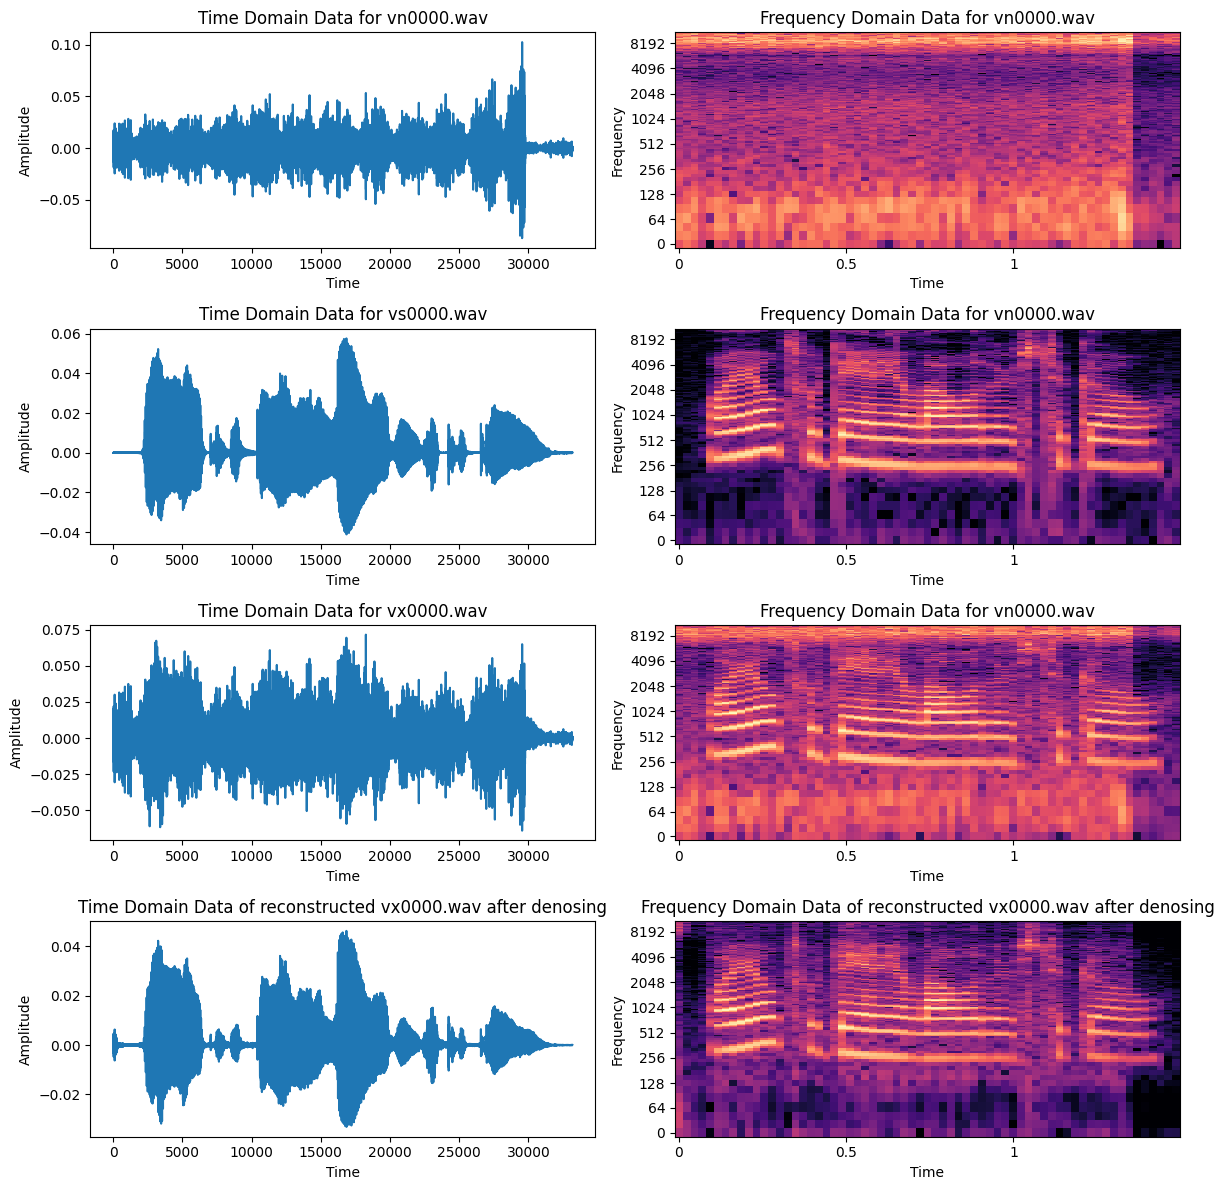

In [22]:
plt.figure(figsize=(12, 12))
plt.subplot(4, 2, 1)
plt.plot(vn_dict_TD['vn0000.wav'])
plt.title('Time Domain Data for vn0000.wav')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(4, 2, 3)
plt.plot(vs_dict_TD['vs0000.wav'])
plt.title('Time Domain Data for vs0000.wav')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(4, 2, 5)
plt.plot(vx_dict_TD['vx0000.wav'])
plt.title('Time Domain Data for vx0000.wav')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(4, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(vn_dict_FD['vn0000.wav'], ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data for vn0000.wav')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(4, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(vs_dict_FD['vs0000.wav'], ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data for vn0000.wav')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(4, 2, 6)
librosa.display.specshow(librosa.amplitude_to_db(vx_dict_FD['vx0000.wav'], ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data for vn0000.wav')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(4, 2, 8)
librosa.display.specshow(librosa.amplitude_to_db(masked_noisy_signal_FD, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data of reconstructed vx0000.wav after denosing')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(4, 2, 7)
plt.plot(recon_masked_noisy_signal_TD)
plt.title('Time Domain Data of reconstructed vx0000.wav after denosing')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
